# High performance computing

So far we've shown you how to access some data in the planetary computer and how to interact with it, but one of the most interesting things in the planetary computer is the ability to call a compute cluster to distribute your data processing in many machines.

This allows us to run big jobs without having to wait around for hours. In this notebooks we show you how to access it.

In [1]:
!pip install python-dotenv -q

In [2]:
import sys
sys.path.append('..')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import stackstac
import rioxarray as rxr
import xarray as xr
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import azure.storage.blob
import os
import dotenv
import zarr

dotenv.load_dotenv()

True

Let's get a data cube we prepared with yearly mosaics for 2000 and 2012 to 2022

In [83]:
# point to the container with all the data so we can just load it
container_client = azure.storage.blob.ContainerClient(
    "https://lcchallenge.blob.core.windows.net/",
    container_name="lc-challenge",
    credential=os.environ['SAS_TOKEN'],
)

store = zarr.ABSStore(client=container_client, prefix="mosaics.zarr")

In [19]:
# open the zarr and get the data variable
da = xr.open_zarr(store, group='mosaic', )['mosaic']

In [20]:
da

<xarray.DataArray 'mosaic' (year: 11, band: 4, y: 40000, x: 40000)>
dask.array<open_dataset-mosaic, shape=(11, 4, 40000, 40000), dtype=uint8, chunksize=(1, 1, 10000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 'red' 'nir' 'swir1' 'swir2'
    spatial_ref  int64 ...
  * x            (x) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0 -60.0
  * y            (y) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0 -20.0
  * year         (year) int64 2000 2012 2013 2014 2016 ... 2019 2020 2021 2022
Attributes:
    AREA_OR_POINT:  Area

So we have 11 time points, 4 bands, and 40000 x 40000 pixels. As you can see above, the entire array is 65.57GB, which is too big to fit into memory, luckily xarray uses dask to deal with this.

As you can see, it has split it into chunks with individual time-points, 1 band and 10000x10000 pixels, so each of them is about 100MB. Right now no data is loaded into memory and everything we do to the array is done 'lazily' (it creates a graph of the computations to be done, and it executes when told so). For instance, below we apply some gain values to convert it to reflectance:

In [22]:
da = da.astype('float32')

# apply gain to red band
da[:,0] = (da[:, 0] - 1) / 508
# apply gain to nir band
da[:,1] = (da[:, 1] - 1) / 254
# apply gain to swir1 band
da[:,2] = (da[:, 2] - 1) / 363
# apply gain to swir2 band
da[:,3] = (da[:, 3] - 1) / 423

this happens almost immediately, which would not be the case if we had to compute it on the entire thing.

In [23]:
da

<xarray.DataArray 'mosaic' (year: 11, band: 4, y: 40000, x: 40000)>
dask.array<setitem, shape=(11, 4, 40000, 40000), dtype=float32, chunksize=(1, 1, 10000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 'red' 'nir' 'swir1' 'swir2'
    spatial_ref  int64 ...
  * x            (x) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0 -60.0
  * y            (y) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0 -20.0
  * year         (year) int64 2000 2012 2013 2014 2016 ... 2019 2020 2021 2022
Attributes:
    AREA_OR_POINT:  Area

imagine now that we want to compute some indices and plot the 11 time points for a small region, let's do so using dask.

We need to specify which cluster of computers is going to take care of doing the operations, we do so using `dask_gateway`

In [26]:
import dask_gateway

In [62]:
# creates the Dask Scheduler, will take a minute or two.
cluster = dask_gateway.GatewayCluster()  

client = cluster.get_client()
# cluster.scale(8)
cluster.adapt(minimum=2, maximum=100)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.72c366c43f974d509a25ad563b8f0def/status


the above creates a cluster that has minimum 2 workers and will automatically scale as it needs to. If you click on the link you can see what's going on with your tasks (specially when we actually trigger some computation)

let's compute a couple of indices and plot them:

In [30]:
da

<xarray.DataArray 'mosaic' (year: 11, band: 4, y: 40000, x: 40000)>
dask.array<setitem, shape=(11, 4, 40000, 40000), dtype=float32, chunksize=(1, 1, 10000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U5 'red' 'nir' 'swir1' 'swir2'
    spatial_ref  int64 ...
  * x            (x) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0 -60.0
  * y            (y) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0 -20.0
  * year         (year) int64 2000 2012 2013 2014 2016 ... 2019 2020 2021 2022
Attributes:
    AREA_OR_POINT:  Area

In [36]:
nbr = (da.sel(band='nir') - da.sel(band='swir1')) / (da.sel(band='nir') + da.sel(band='swir1') + 1e-5)
ndvi = (da.sel(band='nir') - da.sel(band='red')) / (da.sel(band='nir') + da.sel(band='red') + 1e-5)

Now let's plot it through time (as we did in the landsat notebook:

In [33]:
nbr

<xarray.DataArray 'mosaic' (year: 11, y: 40000, x: 40000)>
dask.array<truediv, shape=(11, 40000, 40000), dtype=float32, chunksize=(1, 10000, 10000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0 -60.0
  * y            (y) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0 -20.0
  * year         (year) int64 2000 2012 2013 2014 2016 ... 2019 2020 2021 2022

CPU times: user 1.95 s, sys: 1.17 s, total: 3.12 s
Wall time: 1min 34s


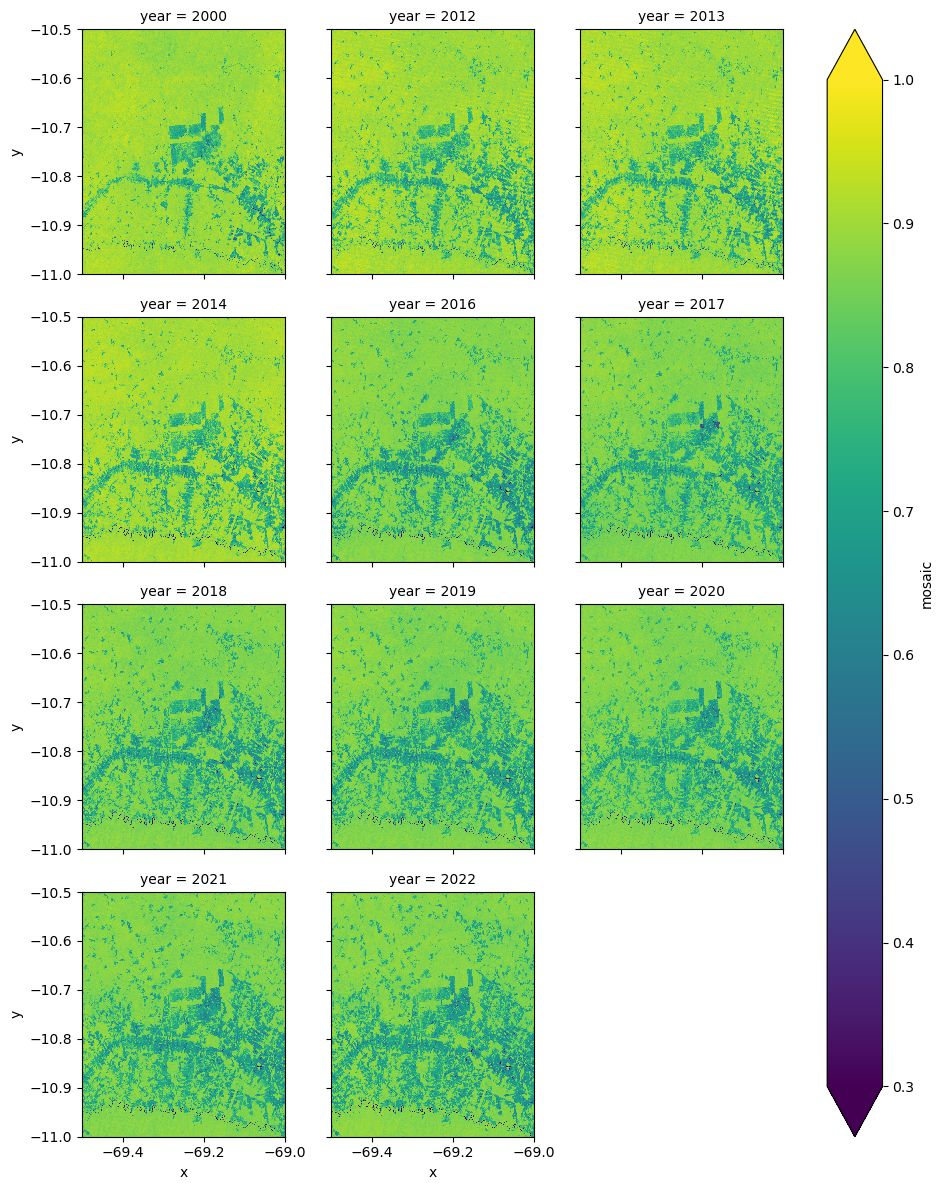

In [38]:
%%time
ndvi.isel(x=slice(2000,4000), y=slice(2000,4000)).plot.imshow(vmin=0.3, vmax=1, col='year', col_wrap=3)

and let's try to get NBR difference for the years 2020 and 2020 computed and into memory (as you can see below it's about 6GB) (look at the dask dashboard!)

In [67]:
nbr_dif = nbr.sel(year=2020) -  nbr.sel(year=2000) #.isel(x=slice(None, 15000), y = slice(None, 15000))
nbr_dif = nbr_dif.rename('NBR difference')

In [68]:
nbr_dif

<xarray.DataArray 'NBR difference' (y: 40000, x: 40000)>
dask.array<sub, shape=(40000, 40000), dtype=float32, chunksize=(10000, 10000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -70.0 -70.0 -70.0 -70.0 ... -60.0 -60.0 -60.0 -60.0
  * y            (y) float64 -10.0 -10.0 -10.0 -10.0 ... -20.0 -20.0 -20.0 -20.0

In [84]:
%%time
computed = nbr_dif.compute()

2024-02-18 19:48:52,851 - distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('sub-5ef618d41be89701bda34a50a4724cf4', 3, 1)": ('tls://10.244.144.180:39983',), "('sub-5ef618d41be89701bda34a50a4724cf4', 1, 0)": ('tls://10.244.144.180:39983',)}


CPU times: user 8.87 s, sys: 59.1 s, total: 1min 7s
Wall time: 3min 42s


2024-02-18 20:03:01,841 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2024-02-18 20:38:06,403 - distributed.client - ERROR - Exception raised while shutting down cluster prod.72c366c43f974d509a25ad563b8f0def
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/dask_gateway/client.py", line 994, in _stop_internal
    await self.gateway._stop_cluster(self.name)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/dask_gateway/client.py", line 655, in _stop_cluster
    await self._request("DELETE", url)
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/dask_gateway/client.py", line 397, in _request
    resp = await session.request(method, url, json=json, **self._request_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/aiohttp/client.py", line 536, in _request
    conn = a

If you've been looking at the dashboard, you'll see that a lot of the time is spent after the tasks have finished, that's when the scheduler puts all the data back together and send it to this notebook instance. Transferring huge amount of data is typically not a great idea, and it might be better to store it in between.

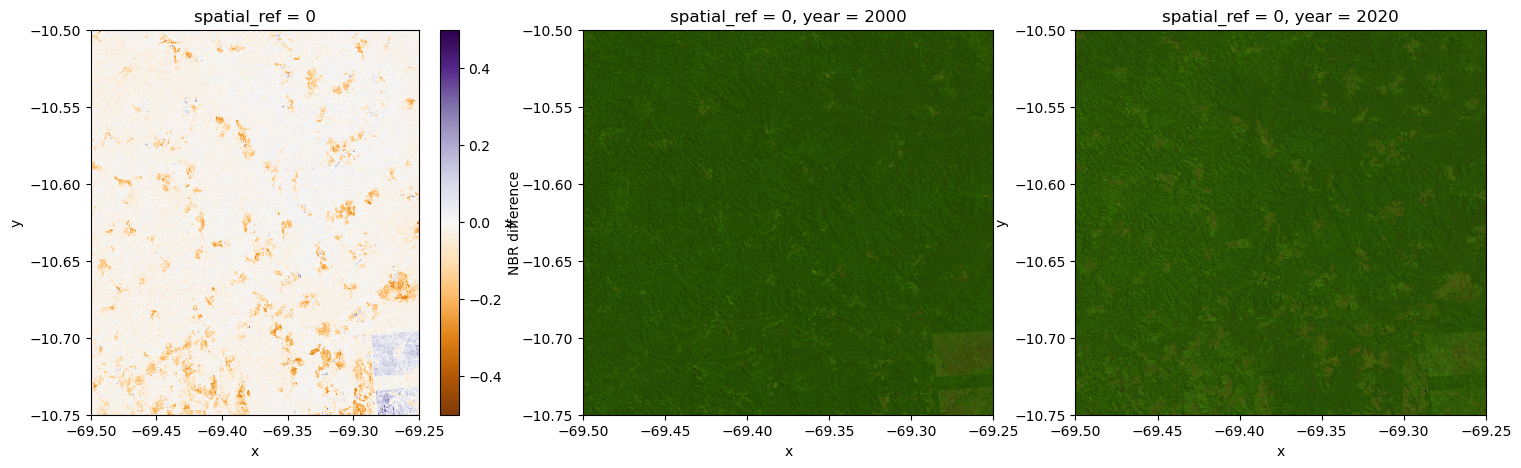

In [82]:
fig, ax = plt.subplots(1,3, figsize=(18, 5))
computed[2000:3000, 2000:3000].plot.imshow(vmin=-0.5, vmax=0.5, cmap='PuOr', ax=ax[0])
da.sel(year=2000)[[2,1,0], 2000:3000, 2000:3000].plot.imshow( vmin=0.005, vmax=1, ax=ax[1])
da.sel(year=2020)[[2,1,0], 2000:3000, 2000:3000].plot.imshow( vmin=0.005, vmax=1, ax=ax[2])

as you can see, several areas that have been deforested have a significant drop in NBR, and the big square patch that seems to be regrowing vegetation has an increase. Perhaps this is a good way to create a deforestation baseline...


### Conclusions

So that's basically it. When you expect to do big computations that need several computers or you can't fit the dataset into memory, you can create a cluster and do them there without changing your code much at all!

Fair warning, if you let it idle for very long, the scheduler will shut down, and you will have to restart it.